In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_gauss_pairs_dataset, get_synthetic_dataset, get_simulated_pairs_dataset, get_multi_pairs_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
x, y, weight, target = get_multi_pairs_dataset(
    data_path="/vol/bitbucket/ad6013/Research/gp-causal/data/multi_pairs/files"
)

In [16]:
from train_methods.gplvm_method import train_conditional_model, train_marginal_model

In [17]:
def causal_score_gplvm(num_inducing, x, y, run_number, restart_number, causal, save_name):
    num_inducing = num_inducing if x.shape[0] > num_inducing else x.shape[0]
    # Dynamically reduce the jitter if there is an error
    # Sample hyperparams
    kernel_variance = 1
    jitter_bug = 1e-6
    finish = 0
    loss_x = None
    # Likelihood variance
    kappa = np.random.uniform(
        low=10.0, high=100, size=[1]
    )
    likelihood_variance = 1. / (kappa ** 2)
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1, high=100, size=[1]
    )
    kernel_lengthscale = 1.0 / lamda
    while finish == 0:
        try:
            tf.print("X" if causal else "Y")
            loss_x = train_marginal_model(
                y=x,
                num_inducing=num_inducing,
                kernel_variance=kernel_variance,
                kernel_lengthscale=kernel_lengthscale[0],
                likelihood_variance=likelihood_variance[0],
                work_dir=None,
                run_number=run_number,
                random_restart_number=restart_number,
                jitter=jitter_bug,
                causal=causal,
                save_name=save_name,
                plot_fit=False,
            )
            finish = 1
        except Exception as e:
            tf.print(e)
            tf.print(f"Increasing jitter to {jitter_bug * 10}")
            jitter_bug *= 10
            if jitter_bug > 1:
                finish = 1
    # Sample hyperparams
    jitter_bug = 1e-6
    finish = 0
    kernel_variance = 1
    # Likelihood variance
    kappa = np.random.uniform(
        low=10.0, high=100, size=[1]
    )
    likelihood_variance = 1. / (kappa ** 2)
    # Kernel lengthscale
    lamda = np.random.uniform(
        low=1.0, high=100, size=[1]
    )
    kernel_lengthscale = 1.0 / lamda
    while finish == 0:
        try:
            tf.print("Y|X" if causal else "X|Y")
            loss_y_x = train_conditional_model(
                x=x,
                y=y,
                num_inducing=num_inducing,
                kernel_variance=kernel_variance,
                kernel_lengthscale=kernel_lengthscale[0],
                likelihood_variance=likelihood_variance[0],
                work_dir=None,
                run_number=run_number,
                random_restart_number=restart_number,
                causal=causal,
                jitter=jitter_bug,
                save_name=save_name,
                plot_fit=False,
            )
            finish = 1
        except Exception as e:
            tf.print(e)
            tf.print(f"Increasing jitter to {jitter_bug * 10}")
            jitter_bug *= 10
            if jitter_bug > 1:
                finish = 1
        if loss_x is None:
            raise ValueError("jitter is more than 1!")
    return (loss_x, loss_y_x)

In [18]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
RANDOM_RESTARTS = 1

correct_idx = []
wrong_idx = []
scores = []

for i in tqdm(range(0, 1), desc="Epochs", leave=True, position=0):
    # Find the target
    run_target = target[i]
    # Ignore the high dim
    if x[i].shape[-1] > 1:
        continue
    tf.print(f'\n Run: {i}')

    # Normalise the data
    x_train = StandardScaler().fit_transform(x[i]).astype(np.float64)
    y_train = StandardScaler().fit_transform(y[i]).astype(np.float64)

    rr_loss_x = []
    rr_loss_y_x = []
    rr_loss_y = []
    rr_loss_x_y = []
    for j in range(RANDOM_RESTARTS):
        seed = RANDOM_RESTARTS * i + j * 10
        np.random.seed(seed)
        tf.random.set_seed(seed)
        tf.print(f"\n Random restart: {j}")
        (
            loss_x,
            loss_y_x,

        ) = causal_score_gplvm(
            num_inducing=200,
            x=x_train,
            y=y_train,
            run_number=i,
            restart_number=j,
            causal=True,
            save_name=None
        )
        (
            loss_y,
            loss_x_y,

        ) = causal_score_gplvm(
            num_inducing=200,
            x=y_train,
            y=x_train,
            run_number=i,
            restart_number=j,
            causal=False,
            save_name=None
        )
        if loss_x is not None:
            rr_loss_x.append(loss_x)
            rr_loss_y_x.append(loss_y_x)
            rr_loss_y.append(loss_y)
            rr_loss_x_y.append(loss_x_y)
            tf.print(loss_x.numpy(), loss_y_x.numpy(), loss_y.numpy(), loss_x_y.numpy())
    # Need to find the best losses from the list
    # Calculate losses

    score_x_y = min(rr_loss_x) + min(rr_loss_y_x)
    score_y_x = min(rr_loss_y) + min(rr_loss_x_y)
    tf.print(f"Run {i}: {score_x_y} ; {score_y_x}")
    if score_x_y < score_y_x:
        # If target is -1 this is wrong
        if run_target < 0:
            wrong_idx.append(i)
        else:
            correct_idx.append(i)
    else:
        if run_target < 0:
            correct_idx.append(i)
        else:
            wrong_idx.append(i)
    scores.append(((min(rr_loss_x).numpy(), min(rr_loss_y_x).numpy()), (min(rr_loss_y).numpy(), min(rr_loss_x_y).numpy())))

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]


 Run: 0

 Random restart: 0
X
Training everything
ELBO: 2138.119081596481
Y|X
Init: ker_len: 0.029008899630334338, ker_var: 1, like_var: 0.00012077208947393991
Breaking as 1820.7748913047308 is less than 1820.8306566664148
Training everything
ELBO: 1607.3194197425328
Y
Breaking as 2128.404052478241 is less than 2128.407799809897
Training everything
ELBO: 2115.9585763736422
X|Y
Init: ker_len: 0.013119900527197918, ker_var: 1, like_var: 0.001293952320525043
Breaking as 1820.6462318582885 is less than 1820.8306573005639
Training everything
ELBO: 1661.9758305129944
2138.119081596481 1607.3194197425328 2115.9585763736422 1661.9758305129944
Run 0: 3745.438501339014 ; 3777.9344068866367


Epochs: 100%|██████████| 1/1 [30:11<00:00, 1811.42s/it]


In [4]:
X, Y = x[0], y[0]
N = X.shape[0]


In [16]:
class gen_data():
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __call__(self):
        for idx in range(len(X)):
            X1 = np.random.randn(1)
            newX = np.concatenate([self.X[idx], X1], axis=0)
            yield newX, self.Y[idx]

In [17]:
# Try and SVGP approach

M = 200  # Number of inducing locations

kernel = gpflow.kernels.SquaredExponential(lengthscales=[0.1, 0.001])
Z = X[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset

m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(variance=1e-4), Z, num_data=N)

In [18]:
from gpflow.ci_utils import ci_niter


minibatch_size = 500

# We turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, True)

train_dataset = tf.data.Dataset.from_generator(
    gen_data(X, Y),
    output_signature=(
         tf.TensorSpec(shape=(2), dtype=tf.float64),
         tf.TensorSpec(shape=(1), dtype=tf.float64))
).repeat().shuffle(N)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(0.005)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [19]:
maxiter = ci_niter(100000)

logf = run_adam(m, maxiter)


In [20]:
print(- m.elbo(data=(X, Y)))

tf.Tensor(1802.4530836395356, shape=(), dtype=float64)


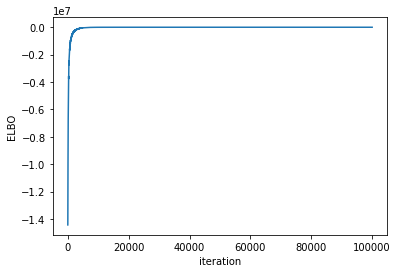

In [21]:
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [22]:
newX = np.linspace(-3, 3, 1000)[:, None]
newX1 = np.random.randn(1000, 1)
newX = np.concatenate([newX, newX1], axis=1)

In [23]:
newX.shape

(1000, 2)

In [24]:
m.kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,4.962069672611872
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[ 7.10235248 344.09983157]


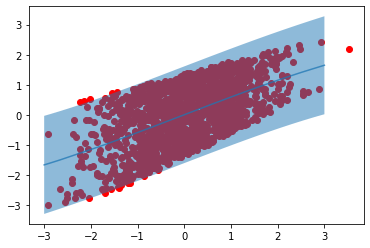

In [25]:
pred_y, var_y = m.predict_y(newX)
plt.scatter(X[:, 0], Y, c='r')
plt.plot(newX[:, 0], pred_y, alpha=0.75)
plt.fill_between(newX[:, 0], (pred_y - 2 * np.sqrt(var_y))[:, 0], (pred_y + 2 * np.sqrt(var_y))[:, 0], alpha=0.5)
plt.show()

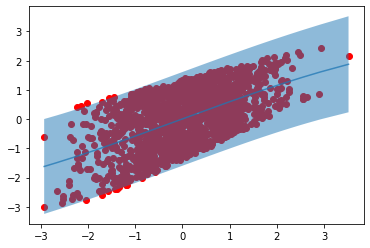

In [26]:
idx = np.argsort(X[:, 0])
oldX = X[idx]
pred_y, var_y = m.predict_y(oldX)
plt.scatter(X[:, 0], Y, c='r')
plt.plot(oldX[:, 0], pred_y, alpha=0.75)
plt.fill_between(oldX[:, 0], (pred_y - 2 * np.sqrt(var_y))[:, 0], (pred_y + 2 * np.sqrt(var_y))[:, 0], alpha=0.5)
plt.show()

In [137]:
idxnp.argsort(X[:, 0])

array([1019, 1270,  632, ...,  436,  318, 1307])

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

In [44]:
[x for x in train_dataset
]

[(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.46147604, -0.38299509])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.87571066])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 1.1931943 , -0.19811754])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.45035299])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.22660697, -1.39880997])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.26226191])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.14348465, -0.06386437])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.19394275])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 1.71940611, -0.11479526])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.65363747])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.09683782, -0.38312005])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.13519484])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.05947657, -0.88570037])

In [47]:
train_dataset = tf.data.Dataset.from_generator(
    gen_data(X, Y),
    output_signature=(
         tf.TensorSpec(shape=(2), dtype=tf.float64),
         tf.TensorSpec(shape=(1), dtype=tf.float64))
)

In [48]:
list(train_dataset.take(1))

[(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.46147604, 0.42292354])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.87571066])>)]

In [49]:
[x for x in train_dataset]

[(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.46147604, -1.17568   ])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.87571066])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 1.1931943 , -0.20485132])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.45035299])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.22660697, 0.95649548])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.26226191])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.14348465,  1.58613399])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.19394275])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.71940611, 0.79128401])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.65363747])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.09683782, -0.55083369])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.13519484])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.05947657, -0.671678  ])>,
 